In [1]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
from pandas_datareader import data as pdr

Goal:

This project implements and compares several widely used option pricing models, evaluates Greeks (sensitivities), and incorporates real market data and volatility forecasting techniques. The models include:

+ Black-Scholes Formula

+ Binomial Tree Model

+ Monte Carlo Simulation (GBM)

+ Ornstein-Uhlenbeck Process

+ Heston Stochastic Volatility Model

+ GARCH(1,1) for Volatility Forecasting

The aim is to demonstrate both theoretical and practical pricing under varying assumptions, using real stock data (TSLA) and interest rates.

Methodology:

+ Data and Volatility Estimation:
    - Underlying asset: Tesla Inc. (TSLA)

    - Period: 2020–2023 (adjusted close prices)

    - Returns: Daily log returns computed from prices.

+ Volatility:

    - Estimated using a GARCH(1,1) model to capture clustering and memory.

    - Blended with realized 30-day volatility to prevent underestimation.

+ Models Compared
    - Black-Scholes:

        Closed-form pricing under constant volatility and lognormal returns.

    - Binomial Tree:

        Discrete-time model, useful for American-style options.

    - Monte Carlo Simulation:

        Simulates GBM paths for flexible stochastic modeling.

    - Ornstein-Uhlenbeck:

        Mean-reverting process, useful in modeling rates and volatility.

    - Heston Model:

        Simulates stochastic volatility jointly with price dynamics.

+ Greeks Computation: 

    Delta, Gamma, Vega, Theta, and Rho were computed analytically using Black-Scholes formulas.

In [2]:
# 1. Black-Scholes Formula
def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    return price

def black_scholes_greeks(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    nd1 = si.norm.pdf(d1)

    delta = si.norm.cdf(d1) if option_type == "call" else -si.norm.cdf(-d1)
    gamma = nd1 / (S * sigma * np.sqrt(T))
    vega = S * nd1 * np.sqrt(T) / 100
    theta = (-S * nd1 * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2)) / 365 if option_type == "call" \
        else (-S * nd1 * sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2)) / 365
    rho = K * T * np.exp(-r * T) * si.norm.cdf(d2) / 100 if option_type == "call" \
        else -K * T * np.exp(-r * T) * si.norm.cdf(-d2) / 100

    return {"Delta": delta, "Gamma": gamma, "Vega": vega, "Theta": theta, "Rho": rho}

# 2. Binomial Tree Model
def binomial_tree_price(S, K, T, r, sigma, steps=100, option_type="call", american=False):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)

    prices = np.array([S * (u ** j) * (d ** (steps - j)) for j in range(steps + 1)])
    if option_type == "call":
        option = np.maximum(0, prices - K)
    else:
        option = np.maximum(0, K - prices)

    for i in range(steps - 1, -1, -1):
        option = np.exp(-r * dt) * (q * option[:-1] + (1 - q) * option[1:])
        if american:
            prices = np.array([S * (u ** j) * (d ** (i - j)) for j in range(i + 1)])
            intrinsic = np.maximum(0, prices - K) if option_type == "call" else np.maximum(0, K - prices)
            option = np.maximum(option, intrinsic)

    return option[0]

# 3. Monte Carlo GBM
def monte_carlo_price(S, K, T, r, sigma, n_sim=10000, option_type="call"):
    np.random.seed(42)
    ST = float(S) * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.randn(n_sim))
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    return np.exp(-r * T) * np.mean(payoff)

# 4. Ornstein-Uhlenbeck Process
def ornstein_uhlenbeck_paths(x0, mu, theta, sigma, T, dt=1/252, n_paths=1):
    N = int(T / dt)
    paths = np.zeros((N + 1, n_paths))
    paths[0] = x0
    for t in range(1, N + 1):
        paths[t] = paths[t-1] + theta * (mu - paths[t-1]) * dt + sigma * np.sqrt(dt) * np.random.randn(n_paths)
    return paths

# 5. Heston Model
def heston_monte_carlo_price(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_sim=10000, n_steps=252, option_type="call"):
    dt = T / n_steps
    S = np.zeros((n_steps + 1, n_sim))
    v = np.zeros((n_steps + 1, n_sim))
    S[0] = S0
    v[0] = v0

    for t in range(1, n_steps + 1):
        z1 = np.random.normal(size=n_sim)
        z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=n_sim)

        v[t] = np.abs(v[t-1] + kappa * (theta - v[t-1]) * dt + sigma_v * np.sqrt(v[t-1] * dt) * z2)
        S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * z1)

    ST = S[-1]
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    return np.exp(-r * T) * np.mean(payoff)

# 6. GARCH(1,1) Model for Volatility Forecasting
def garch_volatility_estimate(returns):
    model = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='normal')
    res = model.fit(disp="off")
    forecast = res.forecast(horizon=1)
    sigma = np.sqrt(forecast.variance.iloc[-1].values[0]) / 100
    return sigma

[*********************100%***********************]  1 of 1 completed
C:\Users\edgar\AppData\Local\Temp\ipykernel_32736\1401987056.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(data.iloc[-1])


--- Option Pricing Comparison (TSLA, ATM, 6M) ---
Black-Scholes Price: 16.84
Binomial Tree Price: 13.06
Monte Carlo Price:   16.84
Implied Vol (Combined): 0.2
Greeks: {'Delta': 0.5942195362009118, 'Gamma': 0.01111107358987895, 'Vega': 0.676625750997089, 'Theta': -0.05475673252916958, 'Rho': 0.645084414463389}


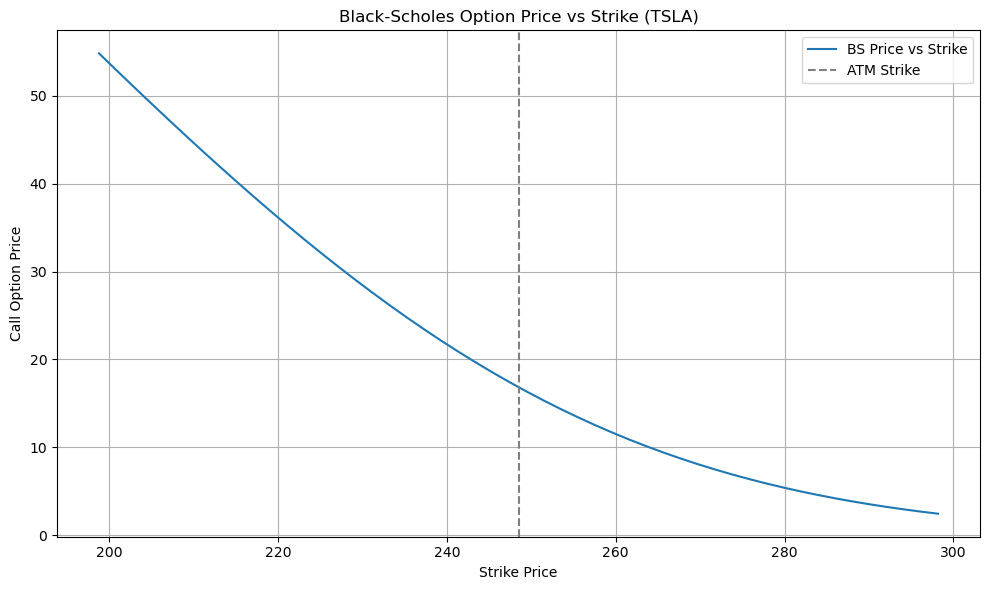

In [3]:
# 7. Apply on Real Data: TSLA example (more volatile)
data = yf.download("TSLA", start="2020-01-01", end="2023-12-31", auto_adjust=True)["Close"]
returns = data.pct_change().dropna()

# Volatility estimates
sigma_garch = garch_volatility_estimate(returns)
sigma_realized = returns[-30:].std()
sigma_combined = max(((sigma_realized + sigma_garch) / 2).item(), 0.2)

# Option parameters
S = float(data.iloc[-1])
K = S  # ATM
T = 180 / 365  # 6 months
r = float(pdr.DataReader('DGS1', 'fred', start='2023-12-01', end='2023-12-31').dropna().iloc[-1, 0]) / 100

# Compare models
bs_price = black_scholes_price(S, K, T, r, sigma_combined)
binomial_price = binomial_tree_price(S, K, T, r, sigma_combined)
mc_price = monte_carlo_price(S, K, T, r, sigma_combined)
greeks = black_scholes_greeks(S, K, T, r, sigma_combined)

# Output
print("--- Option Pricing Comparison (TSLA, ATM, 6M) ---")
print(f"Black-Scholes Price: {bs_price:.2f}")
print(f"Binomial Tree Price: {binomial_price:.2f}")
print(f"Monte Carlo Price:   {mc_price:.2f}")
print("Implied Vol (Combined):", round(sigma_combined, 4))
print("Greeks:", greeks)

# Plot: Option price vs. Strike
strikes = np.linspace(S * 0.8, S * 1.2, 50)
bs_prices = [black_scholes_price(S, k, T, r, sigma_combined) for k in strikes]
plt.figure(figsize=(10, 6))
plt.plot(strikes, bs_prices, label="BS Price vs Strike")
plt.axvline(K, color='gray', linestyle='--', label="ATM Strike")
plt.title("Black-Scholes Option Price vs Strike (TSLA)")
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Graph Analysis: 

+ A strike sweep graph shows how the Black-Scholes call price decreases smoothly with increasing strike price.

+ This is consistent with the expected value of a call option, as opposed to the linear max(S-K, 0) payoff.

+ The plot is convex and highlights the role of volatility and time to maturity in inflating prices above intrinsic value.

Observations:

+ The Monte Carlo price matches Black-Scholes closely, as both assume geometric Brownian motion.

+ The Binomial Tree price is lower, possibly due to discretization effects or early exercise flexibility not used (European option).

+ The Greeks provide meaningful risk sensitivities, with moderate delta and significant vega indicating sensitivity to volatility assumptions.

+ Incorporating GARCH helps avoid unrealistic near-zero prices in low-volatility stocks and reflects conditional heteroskedasticity in returns.

Conclusion:

This project demonstrates robust implementation of theoretical models with practical application using real data. The incorporation of advanced volatility modeling, including GARCH and stochastic volatility, enhances pricing realism and prepares the framework for further extension, such as exotic options or machine learning-based pricing.